In [17]:

import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import os
import math
import random
import string
import cv2
import re

In [20]:
# Define the path to this directory
PATH = os.path.abspath("") + "/"

# Control whether to process the raw placards or the processed placards
PROCESS_RAW_PLACARDS = False


### Process the Initial Plates as needed

In [3]:
def slicePlacards():
    placard_path = PATH + "parking_spot_numbers"
    # Create sub-images directory if it doesn't exist
    slicedimage_path = os.path.join(PATH, "sliced_images")

    if not os.path.exists(slicedimage_path):
        os.mkdir(slicedimage_path)

    # Get the list of files in placard_path
    placard_files = os.listdir(placard_path)

    # Loop through each file and apply slicing
    for filename in placard_files:
        # Construct the full path of the input file
        input_file = os.path.join(placard_path, filename)

        # Read the image
        image = cv2.imread(input_file)

        # Calculate the positions of the horizontal and vertical lines based on the size of the image
        height, width, _ = image.shape
        x1 = int(0.52 * width)
        x2 = int(0.97 * width)
        y1 = int(0.4 * height)
        y2 = int(0.72 * height)

        # Crop the rectangle formed by the four points
        cropped_image = image[y1:y2, x1:x2]

        # Save the cropped image using the original filename
        output_filename = os.path.splitext(filename)[0] + "_cropped.png"
        output_dir = os.path.join(slicedimage_path, output_filename)
        cv2.imwrite(output_dir, cropped_image)
if (PROCESS_RAW_PLACARDS):
    slicePlacards()


### Image Preprocessing

In [4]:
def preprocess_image(img):
    # Convert the image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize the image to 20x25
    img = cv2.resize(img, (25, 20))


    return img

### Prepare Training Set with Labeling and Histogram of Data

In [5]:
slicedimage_path = os.path.join(PATH, "sliced_images")

def get_label(file_name):
    """
    Extracts the label from the filename.

    The label is assumed to be the first character of the filename, which is always an integer.

    Args:
        file_name (str): The name of the image file.

    Returns:
        int: The label of the image.

    Raises:
        None
    """
    # Extract the first character of the filename
    label_char = file_name[0]
    # Convert the label to an integer
    label = int(label_char)
    # Return the label
    return label

# Get the list of files in slicedimage_path
sliced_files = os.listdir(slicedimage_path)

# Initialize empty arrays for parking number images and labels
parking_number_set = []
labels = []

# Loop through each file in slicedimage_path
for file_name in sliced_files:
    # Load the image and convert to RGB format
    image = cv2.imread(os.path.join(slicedimage_path, file_name))[:,:,::-1]
    image = preprocess_image(image)
    # Add the image and label to the arrays
    parking_number_set.append(image)
    label = get_label(file_name)
    labels.append(label)

# Convert the arrays to numpy arrays
parking_number_set = np.array(parking_number_set)
labels = np.array(labels)

# Print the number of elements added to parking_number_set and the number of images in the set
print("Loaded {:} images from folder:\n{}".format(parking_number_set.shape[0], slicedimage_path))
print("Loaded {:} labels.".format(labels.shape[0]))

# Pair the images and labels together for shuffling
parking_number_list = []
for i in range(len(parking_number_set)):
    parking_number_list.append((parking_number_set[i], labels[i]))

Loaded 3348 images from folder:
/home/sghyseli/cnn_trainer/cnn_parking_numbers/sliced_images
Loaded 3348 labels.


In [6]:
# Shuffle the dataset
np.random.shuffle(parking_number_list)

# Split the parking_number_list to X_dataset and Y_dataset
X_dataset_raw = np.array([pair[0] for pair in parking_number_list])
Y_dataset_raw = np.array([pair[1] for pair in parking_number_list])

# Print the shape of X_dataset and Y_dataset
print("X_dataset shape:", X_dataset_raw.shape)
print("Y_dataset shape:", Y_dataset_raw.shape)


X_dataset shape: (3348, 20, 25)
Y_dataset shape: (3348,)


In [7]:
NUMBER_OF_LABELS = 8
CONFIDENCE_THRESHOLD = 0.01
# Define the labels
labels = [1, 2, 3, 4, 5, 6, 7, 8]

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

Y_indices = np.array([labels.index(pair[1]) for pair in parking_number_list])

Y_dataset = convert_to_one_hot(Y_indices, NUMBER_OF_LABELS).T
# Normalize X (images) dataset
X_dataset = X_dataset_raw/255






In [8]:

# Print the first 10 elements of Y_indices and Y_dataset
print("Y_indices[:10]:", Y_indices[:10])
print("Y_dataset[:10]:\n", Y_dataset[:10])
# Print the shape of X_dataset and Y_dataset
print("X_dataset shape:", X_dataset.shape)
print("Y_dataset shape:", Y_dataset.shape)

Y_indices[:10]: [2 3 1 0 4 1 4 2 3 6]
Y_dataset[:10]:
 [[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]
X_dataset shape: (3348, 20, 25)
Y_dataset shape: (3348, 8)


In [9]:
from ipywidgets import interact
import ipywidgets as ipywidgets

# Display images in the training data set. 
def displayImage(index):
  plt.imshow(X_dataset[index])
  caption = ("y = " + "Parking ID # " + str(labels[Y_indices[index]]) + \
              "\n" +  "  " +  str(Y_dataset[index]))
  #str(np.squeeze(Y_dataset_orig[:, index])))
  plt.text(0.5, 0.5, caption, 
          color='black', fontsize = 20,
          horizontalalignment='left', verticalalignment='top')


interact(displayImage, 
         index=ipywidgets.IntSlider(min=0, max=X_dataset.shape[0]-1,
                                    step=1, value=10))
#displayImage(2)

interactive(children=(IntSlider(value=10, description='index', max=3347), Output()), _dom_classes=('widget-int…

<function __main__.displayImage(index)>

In [10]:
print(X_dataset.shape)

(3348, 20, 25)


### Validate the Data and Distribution

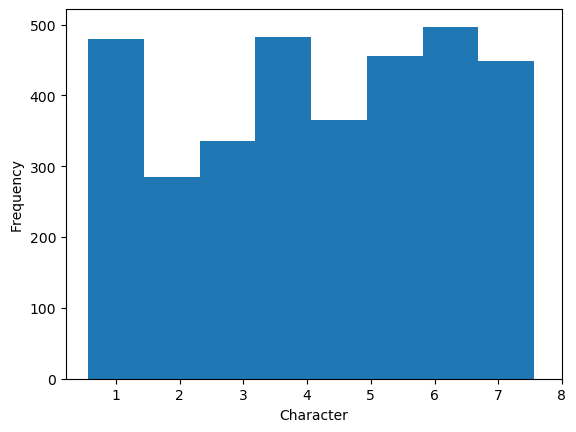

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define a list of characters that could appear in the license plates
labels = ['1', '2', '3', '4', '5', '6', '7', '8']


# Y_indices is an integer array containing the index of the character in the labels list
Y = Y_indices
X = X_dataset

# Create a histogram of Y_indices
plt.hist(Y_indices, bins=8, align='left')
plt.xticks(np.arange(len(labels)), labels)
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.show()



### Set a Training and Validation Set

In [12]:
VALIDATION_SPLIT = 0.2

# Create a dictionary to store the indices of the samples for each character type:
char_indices = {}
for char in range(len(labels)):
    char_indices[char] = np.where(Y_indices == char)[0]

# For each character type, randomly shuffle the corresponding indices and 
# split them into training and validation sets based on a given ratio 
# (e.g., 0.8 for 80% training and 20% validation):
train_indices = []
val_indices = []
for char in range(len(labels)):
    char_indices_shuffled = np.random.permutation(char_indices[char])
    split_index = int(len(char_indices_shuffled) * (1-VALIDATION_SPLIT))
    train_indices.extend(char_indices_shuffled[:split_index])
    val_indices.extend(char_indices_shuffled[split_index:])

X_train_dataset = X_dataset[train_indices,:,:]
Y_train_dataset = Y_dataset[train_indices,:]
Y_train_indices = Y_indices[train_indices]

X_val_dataset = X_dataset[val_indices,:,:]
Y_val_dataset = Y_dataset[val_indices,:]
Y_val_indices = Y_indices[val_indices]



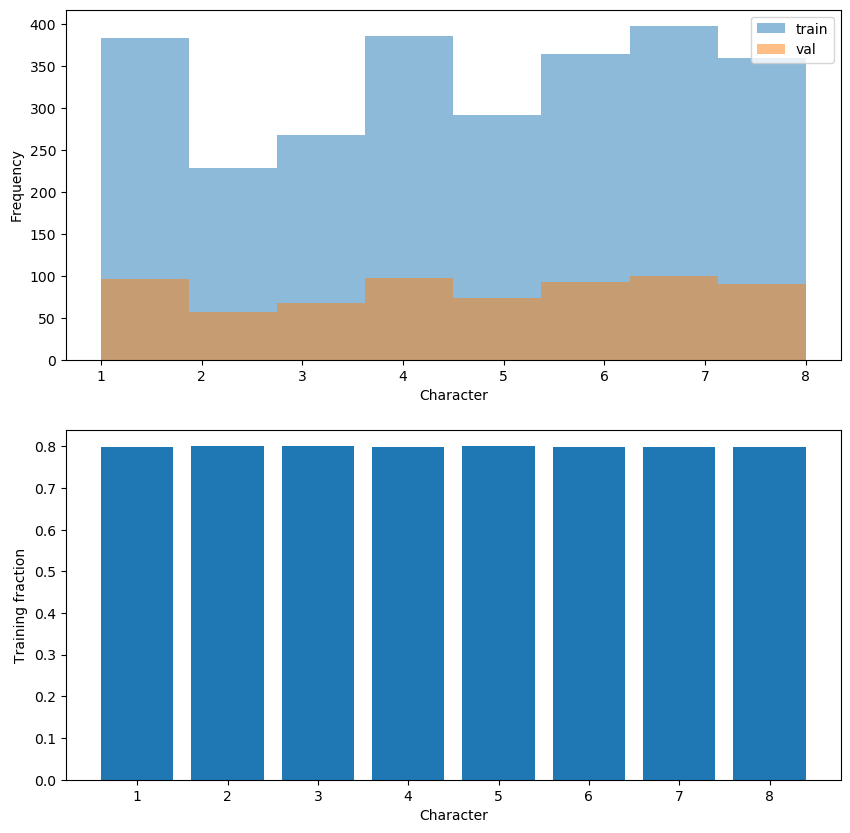

X shape: (3348, 20, 25)
Y shape: (3348, 8)
Total examples: 3348
Training examples: 2676
Validation examples: 672


In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

train_hist, train_bins, _ = ax1.hist(Y_train_indices, bins=len(labels), alpha=0.5, label='train')
val_hist, val_bins, _ = ax1.hist(Y_val_indices, bins=len(labels), alpha=0.5, label='val')
ax1.set_xlabel('Character')
ax1.set_ylabel('Frequency')
ax1.set_xticks(np.arange(len(labels)))
ax1.set_xticklabels(labels)
ax1.legend()

ax2.bar(np.arange(len(labels)), train_hist/(train_hist+val_hist))
ax2.set_xlabel('Character')
ax2.set_ylabel('Training fraction')
ax2.set_xticks(np.arange(len(labels)))
ax2.set_xticklabels(labels)

plt.show()

print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))
print("Total examples: {:d}\nTraining examples: {:d}\n"
      "Validation examples: {:d}".
      format(X_dataset.shape[0],
             X_train_dataset.shape[0],
             X_val_dataset.shape[0]))

### Train the CNN on the Dataset

In [6]:
from keras import layers
from keras import models
from keras import optimizers
from keras.utils import plot_model
from keras import backend

In [7]:
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and 
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

### Define the CNN Model

In [ ]:
MODEL_NAME = "model2"

#Reshape the dataset so that has a single channel for Greyscale and we can use it for 22Conv
#X_dataset = np.reshape(X_dataset, (-1, 20, 25, 1))

# Model 2
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(20, 25, 1)))  # Include the channel dimension in input_shape
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(128, activation='relu'))
conv_model.add(layers.Dense(8, activation='softmax'))





In [ ]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 23, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 11, 16)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 9, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 4, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dropout (Dropout)           (None, 384)               0

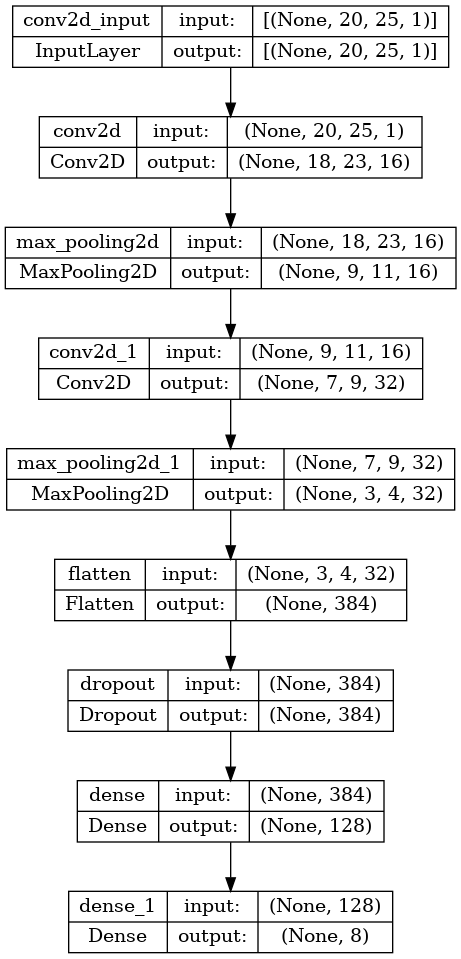

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(conv_model, to_file= MODEL_NAME + '.png', show_shapes=True, show_layer_names=True)

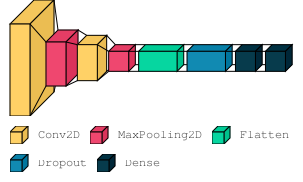

In [11]:
#https://www.analyticsvidhya.com/blog/2022/03/visualize-deep-learning-models-using-visualkeras/
# Visualization of the model
import visualkeras
visualkeras.layered_view(conv_model, legend=True) # without custom font
from PIL import ImageFont
font = ImageFont.truetype("FreeMono.ttf", 12)
visualkeras.layered_view(conv_model, legend=True, font=font) # selected font

### Set Training

In [ ]:
# Boolean to set training on or off for run
train = 1

import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import ModelCheckpoint

# Create the weights folder if it doesn't exist
weights_dir = os.path.join(PATH, "weights")
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

# Define the configuration parameters
config = {
    "learning_rate": 1e-4,
    "optimizer": "RMSprop",
    "loss_function": "categorical_crossentropy",
    "metrics": ["accuracy"],
    "epochs": 140,
    "batch_size": 32,
}

# Create a ModelCheckpoint callback to save weights 
checkpoint = ModelCheckpoint(
    filepath=os.path.join(weights_dir, 'epoch_{epoch:02d}.h5'),  # Filepath pattern to save the weights
    save_weights_only=True,  # Set to True to save only weights, not the whole model
    save_freq='epoch',  # Save the weights after every epoch
    period=5,  # Save the weights every 10 epochs
    verbose=1  # Verbosity level, 1 means to print information about saved weights
)


conv_model.compile(loss=config["loss_function"],
                   optimizer=optimizers.RMSprop(lr=config["learning_rate"]),
                   metrics=['acc'])



if(train == 1):
    reset_weights(conv_model)
    # start a new wandb run to track this script
    wandb.init(project="Parking_ID", config=config)

    history_conv = conv_model.fit(X_train_dataset, Y_train_dataset, 
                                validation_data=(X_val_dataset, Y_val_dataset), 
                                epochs=config["epochs"], 
                                batch_size=config["batch_size"],
                                callbacks=[WandbCallback(), checkpoint])
    
    # [optional] finish the wandb run, necessary in notebooks
    wandb.finish()

    


### Display metrics

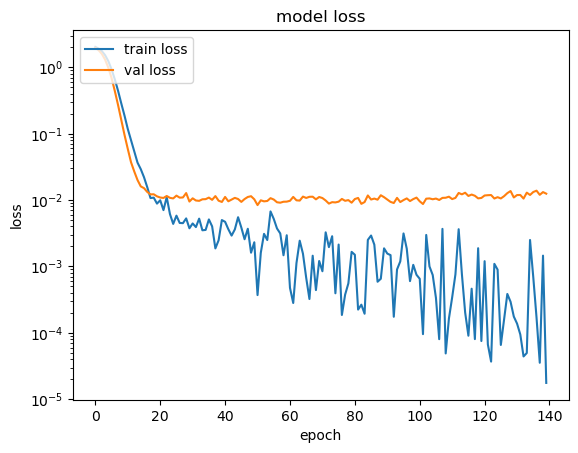

In [38]:
if(train == 1):
  # convert y-axis to Logarithmic scale
  plt.yscale("log")
  plt.plot(history_conv.history['loss'])
  plt.plot(history_conv.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'val loss'], loc='upper left')
  plt.show()

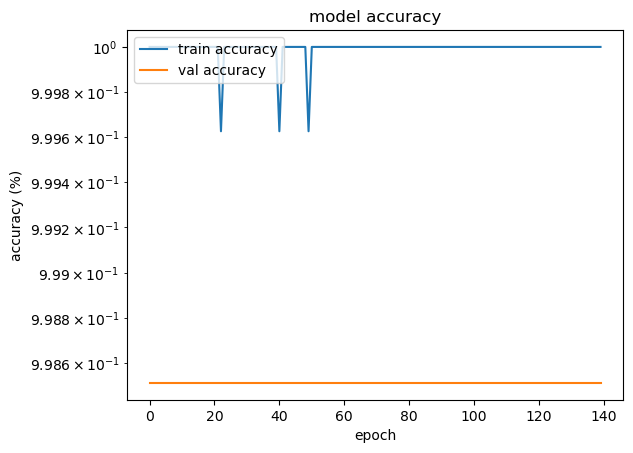

In [34]:
if(train == 1):
  # convert y-axis to Logarithmic scale
  plt.yscale("log")
  plt.plot(history_conv.history['acc'])
  plt.plot(history_conv.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy (%)')
  plt.xlabel('epoch')
  plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
  plt.show()

In [20]:
if (train == 1):
    # serialize model to JSON
    model_json = conv_model.to_json()
    with open(os.path.join(PATH, f"{MODEL_NAME}.json"), "w") as json_file:  # Use MODEL_NAME here
        json_file.write(model_json)
    # serialize weights to HDF5
    conv_model.save_weights(os.path.join(PATH, f"{MODEL_NAME}.h5"))  # Use MODEL_NAME here
    print("Saved model to disk")

Saved model to disk


In [21]:
from keras.models import Sequential, model_from_json
# load json and create model

# load json and create model
with open(os.path.join(PATH, "model.json"), 'r') as json_file:
    loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights(os.path.join(PATH, "model.h5"))
print("Loaded model from disk")

Loaded model from disk


In [29]:
weights_dir = os.path.join(PATH, "weights")

print("Weights will be saved to:", os.path.join(weights_dir, 'epoch_{epoch:02d}.h5'))

Weights will be saved to: /home/sghyseli/cnn_trainer/cnn_parking_numbers/weights/epoch_{epoch:02d}.h5
